In [1]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchmetrics,matplotlib

torch            : 1.10.1
pytorch_lightning: 1.6.0.dev0
torchmetrics     : 0.6.2
matplotlib       : 3.3.4



In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore W291,W293,E703

<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# Model Zoo -- LeNet-5 Trained on QuickDraw

This notebook implements the classic LeNet-5 convolutional network [1] and applies it to MNIST digit classification. The basic architecture is shown in the figure below:

![](../../pytorch_ipynb/images/lenet/lenet-5_1.jpg)



LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). In total, LeNet-5 consists of only 7 layers. 3 out of these 7 layers are convolutional layers (C1, C3, C5), which are connected by two average pooling layers (S2 & S4). The penultimate layer is a fully connexted layer (F6), which is followed by the final output layer. The additional details are summarized below:

- All convolutional layers use 5x5 kernels with stride 1.
- The two average pooling (subsampling) layers are 2x2 pixels wide with stride 1.
- Throughrout the network, tanh sigmoid activation functions are used. (**In this notebook, we replace these with ReLU activations**)
- The output layer uses 10 custom Euclidean Radial Basis Function neurons for the output layer. (**In this notebook, we replace these with softmax activations**)
- The expected input size is 32x32; so, here, we rescale the Quickdraw images from 28x28 to 32x32 to match this input dimension. Alternatively, we would have to change the 
achieve error rate below 1% on the MNIST data set, which was very close to the state of the art at the time (produced by a boosted ensemble of three LeNet-4 networks).


### References

- [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. [Gradient-based learning applied to document recognition](https://ieeexplore.ieee.org/document/726791). Proceedings of the IEEE, november 1998.

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings
- Note that for small datatsets, it is not necessary and better not to use multiple workers as it can sometimes cause issues with too many open files in PyTorch. So, if you have problems with the data loader later, try setting `NUM_WORKERS = 0` instead.

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
NUM_WORKERS = 4

## Implementing a Neural Network using PyTorch Lightning's `LightningModule`

- In this section, we set up the main model architecture using the `LightningModule` from PyTorch Lightning.
- We start with defining our neural network  model in pure PyTorch, and then we use it in the `LightningModule` to get all the extra benefits that PyTorch Lightning provides.

In [4]:
import torch


class PyTorchLeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super().__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.classifier(x)
        return logits

In [5]:
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    # Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        
        # To account for Dropout behavior during evaluation
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Setting up the dataset

- In this section, we are going to set up our dataset.

- Here, we are going to use Google's Quickdraw dataset (https://quickdraw.withgoogle.com). 
- In particular we will be working with an arbitrary subset of 10 categories in PNG format:

    label_dict = {
             "lollipop": 0,
             "binoculars": 1,
             "mouse": 2,
             "basket": 3,
             "penguin": 4,
             "washing machine": 5,
             "canoe": 6,
             "eyeglasses": 7,
             "beach": 8,
             "screwdriver": 9,
    }
    
For more details on obtaining and preparing the dataset, please see the

- [custom-data-loader-quickdraw.ipynb](../../pytorch_ipynb/mechanics/custom-data-loader-quickdraw.ipynb)

notebook.

### Inspecting the dataset

In [6]:
%matplotlib inline

(28, 28)


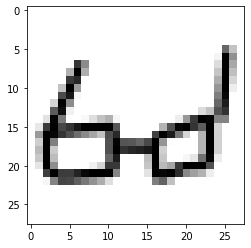

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image


df = pd.read_csv('quickdraw_png_set1_train.csv', index_col=0)
df.head()

main_dir = 'quickdraw-png_set1/'

img = Image.open(os.path.join(main_dir, df.index[2]))
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(np.array(img), cmap='binary')
plt.show()

### Creating a custom Dataset and DataLoader

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df['Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [9]:
custom_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_train.csv',
                                 img_dir='quickdraw-png_set1/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS) 

valid_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_valid.csv',
                                 img_dir='quickdraw-png_set1/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS) 

test_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_test.csv',
                                img_dir='quickdraw-png_set1/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS) 

In [10]:
from collections import Counter


train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

print('\nTraining label distribution:')
sorted(train_counter.items(), key=lambda pair: pair[0])


Training label distribution:


[(0, 90149),
 (1, 87122),
 (2, 125242),
 (3, 82893),
 (4, 178028),
 (5, 84541),
 (6, 86707),
 (7, 158087),
 (8, 87143),
 (9, 81109)]

In [11]:
valid_counter = Counter()
for images, labels in valid_loader:
    valid_counter.update(labels.tolist())

print('\nValidation label distribution:')
sorted(valid_counter.items(), key=lambda pair: pair[0])


Validation label distribution:


[(0, 12944),
 (1, 12260),
 (2, 17938),
 (3, 11773),
 (4, 25347),
 (5, 12089),
 (6, 12220),
 (7, 22679),
 (8, 12657),
 (9, 11668)]

In [12]:
test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print('\nTest label distribution:')
sorted(test_counter.items(), key=lambda pair: pair[0])


Test label distribution:


[(0, 25756),
 (1, 24808),
 (2, 35646),
 (3, 23792),
 (4, 50416),
 (5, 24221),
 (6, 24840),
 (7, 44996),
 (8, 25138),
 (9, 23536)]

### Performance baseline

- Especially for imbalanced datasets, it's quite useful to compute a performance baseline.
- In classification contexts, a useful baseline is to compute the accuracy for a scenario where the model always predicts the majority class -- you want your model to be better than that!

In [13]:
majority_class = test_counter.most_common(1)[0]
majority_class

(4, 50416)

In [14]:
baseline_acc = majority_class[1] / sum(test_counter.values())
print('Accuracy when always predicting the majority class:')
print(f'{baseline_acc:.2f} ({baseline_acc*100:.2f}%)')

Accuracy when always predicting the majority class:
0.17 (16.63%)


### Setting up a `DataModule`

- There are three main ways we can prepare the dataset for Lightning. We can
  1. make the dataset part of the model;
  2. set up the data loaders as usual and feed them to the fit method of a Lightning Trainer -- the Trainer is introduced in the next subsection;
  3. create a LightningDataModule.
- Here, we are going to use approach 3, which is the most organized approach. The `LightningDataModule` consists of several self-explanatory methods as we can see below:


In [15]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        
    def prepare_data(self):
        # We assume the dataset is already downloaded, otherwise
        # put the code for downloading it here
        self.resize_transform = transforms.Compose(
            [transforms.Resize((32, 32)),
             transforms.ToTensor()])
        return

    def setup(self, stage=None):
        # Note transforms.ToTensor() scales input images
        # to 0-1 range
        self.train = QuickdrawDataset( 
            txt_path=os.path.join(
                self.data_path, 'quickdraw_png_set1_train.csv'),
            img_dir=os.path.join(self.data_path, 'quickdraw-png_set1/'),
            transform=self.resize_transform)

        self.valid = QuickdrawDataset( 
            txt_path=os.path.join(
                self.data_path, 'quickdraw_png_set1_valid.csv'),
            img_dir=os.path.join(self.data_path, 'quickdraw-png_set1/'),
            transform=self.resize_transform)        

        self.test = QuickdrawDataset( 
            txt_path=os.path.join(
                self.data_path, 'quickdraw_png_set1_test.csv'),
            img_dir=os.path.join(self.data_path, 'quickdraw-png_set1/'),
            transform=self.resize_transform)

    def train_dataloader(self):
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=True,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=self.valid, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(dataset=self.test, 
                                 batch_size=BATCH_SIZE, 
                                 drop_last=False,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS)
        return test_loader

- Note that the `prepare_data` method is usually used for steps that only need to be executed once, for example, downloading the dataset; the `setup` method defines the the dataset loading -- if you run your code in a distributed setting, this will be called on each node / GPU. 
- Next, lets initialize the `DataModule`; we use a random seed for reproducibility (so that the data set is shuffled the same way when we re-execute this code):

In [16]:
torch.manual_seed(1) 
data_module = DataModule(data_path='./')

## Training the model using the PyTorch Lightning Trainer class

- Next, we initialize our model.
- Also, we define a call back so that we can obtain the model with the best validation set performance after training.
- PyTorch Lightning offers [many advanced logging services](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) like Weights & Biases. Here, we will keep things simple and use the `CSVLogger`:

In [17]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = PyTorchLeNet5(
    num_classes=10, grayscale=True)

lightning_model = LightningModel(
    model=pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="my-model")

- Now it's time to train our model:

In [18]:
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=1000)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | model     | PyTorchLeNet5 | 61.7 K
1 | train_acc | Accuracy      | 0     
2 | valid_acc | Accuracy      | 0     
3 | test_acc  | Accuracy      | 0     
--------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 21.72 min in total.


## Evaluating the model

- After training, let's plot our training ACC and validation ACC using pandas, which, in turn, uses matplotlib for plotting (you may want to consider a [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) that does that for you):

<AxesSubplot:xlabel='Epoch', ylabel='ACC'>

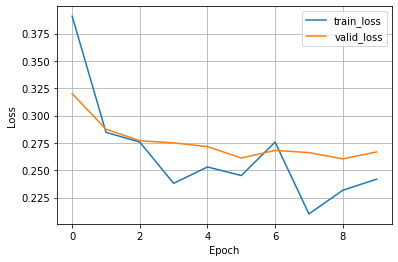

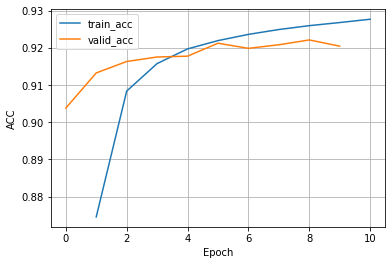

In [19]:
import pandas as pd


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

- The `trainer` automatically saves the model with the best validation accuracy automatically for us, we which we can load from the checkpoint via the `ckpt_path='best'` argument; below we use the `trainer` instance to evaluate the best model on the test set:

In [20]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

Restoring states from the checkpoint path at logs/my-model/version_36/checkpoints/epoch=8-step=74600.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my-model/version_36/checkpoints/epoch=8-step=74600.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9217909574508667     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9217909574508667}]

## Predicting labels of new data

- You can use the `trainer.predict` method on a new `DataLoader` or `DataModule` to apply the model to new data.
- Alternatively, you can also manually load the best model from a checkpoint as shown below:

In [21]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/my-model/version_36/checkpoints/epoch=8-step=74600.ckpt


In [22]:
lightning_model = LightningModel.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();

- Note that our PyTorch model, which is passed to the Lightning model, requires input arguments. However, this is automatically being taken care of since we used `self.save_hyperparameters()` in our PyTorch model's `__init__` method.
- Now, below is an example applying the model manually. Here, pretend that the `test_dataloader` is a new data loader.

In [23]:
test_dataloader = data_module.test_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in test_dataloader:
    features, labels = batch
    
    with torch.no_grad():  # since we don't need to backprop
        logits = lightning_model(features)
    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels = torch.cat(all_predicted_labels)
all_true_labels = torch.cat(all_true_labels)
all_predicted_labels[:5]

tensor([7, 1, 3, 4, 9])

Just as an internal check, if the model was loaded correctly, the test accuracy below should be identical to the test accuracy we saw earlier in the previous section.

In [24]:
test_acc = torch.mean((all_predicted_labels == all_true_labels).float())
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.9218 (92.18%)


## Single-image usage

In [25]:
%matplotlib inline

In [26]:
import matplotlib.pyplot as plt

- Assume we have a single image as shown below:

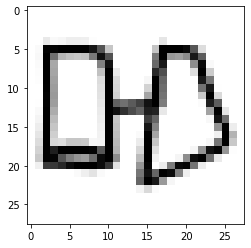

In [27]:
from PIL import Image


image = Image.open('./quickdraw-png_set1/binoculars/binoculars_093136.png')
plt.imshow(image, cmap='Greys')
plt.show()

- Note that we used a resize-transformation in the `DataModule` that rescaled the 28x28 images to size 32x32. We also have to apply the same transformation to any new image that we feed to the model:

In [28]:
resize_transform = transforms.Compose(
            [transforms.Resize((32, 32)),
             transforms.ToTensor()])

image_chw = resize_transform(image)

- Note that `ToTensor` returns the image in the CHW format. CHW refers to the dimensions and stands for channel, height, and width.

In [29]:
print(image_chw.shape)

torch.Size([1, 32, 32])


- However, the PyTorch / PyTorch Lightning model expectes images in NCHW format, where N stands for the number of images (e.g., in a batch).
- We can add the additional channel dimension via `unsqueeze` as shown below:

In [30]:
image_nchw = image_chw.unsqueeze(0)
print(image_nchw.shape)

torch.Size([1, 1, 32, 32])


- Now that we have the image in the right format, we can feed it to our classifier:

In [31]:
with torch.no_grad():  # since we don't need to backprop
    logits = lightning_model(image_nchw)
    probas = torch.softmax(logits, axis=1)
    predicted_label = torch.argmax(probas)

In [34]:
label_dict = {
         0: "lollipop",
         1: "binoculars",
         2: "mouse",
         3: "basket",
         4: "penguin",
         5: "washing machine",
         6: "canoe",
         7: "eyeglasses",
         8: "beach",
         9: "screwdriver",
}

In [35]:
print(f'Predicted label: {label_dict[predicted_label.item()]}')
print(f'Class-membership probability {probas[0][predicted_label]*100:.2f}%')

Predicted label: binoculars
Class-membership probability 99.95%
